In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from DataLoader.Dataloader import HyperEdgeDataset
from DataLoader.Dataloader_directed import HyperDiEdgeDataset
from itertools import chain
import seaborn as sns
import pathlib
import os
plt.rcParams['text.usetex'] = True

resultpath ='nodeevent_directed/'
files = ['enron', 'eumail', 'hepth', 'arxiv', 'twitter']


In [3]:
## Created Custom Iterator For Getting Conn Probability from Text or CSV File
class IteratorForConnProb:
    def __init__(self, filepath, dtype , mtype) -> None:
        if 'csv' == filepath[-3:]:
            self.file = pd.read_csv(filepath)
            self.cur_index = 0
            self.ftype = 'csv'
        else:
            with open(filepath,'r') as f:
                self.file = f.readlines()
            self.cur_index = 1
            self.ftype = 'txt'
        self.dtype = dtype
        self.mtype = mtype
        self.filesize = len(self.file)
        

    def getNext(self):
        self.cur_index +=1
        if self.ftype == 'csv':
            if self.mtype == 'undirected':
                return (self.file['right_size'][self.cur_index - 1], self.file['left_size'][self.cur_index - 1] ,  self.file['Conn Proba'][self.cur_index - 1].split())
            elif self.mtype == 'directed':
                return (self.file['right_size'][self.cur_index - 1], self.file['left_size'][self.cur_index - 1] , self.file['Conn Proba Right'][self.cur_index - 1].split() , self.file['Conn Proba Left'][self.cur_index - 1].split())
            else:
                raise NotImplementedError
        else:
            cur_result = self.file[self.cur_index - 1].split(', ')
            if self.mtype == 'undirected':
                return (int(cur_result[1].strip()), int(cur_result[2].strip()), cur_result[-1].strip()[1:-2].split())
            elif self.mtype == 'directed':
                return (int(cur_result[1].strip()), int(cur_result[2].strip()), cur_result[-2].strip()[1:-2].split() , cur_result[-1].strip()[1:-2].split())
            else:
                raise NotImplementedError

    def hasNext(self):
        return self.cur_index < self.filesize
    


In [4]:

def recall_at_K(edge, top_k):
    recall = np.zeros(len(edge))
    for i, node in enumerate(edge):
        recall[i] = len(np.intersect1d(edge, top_k[i])) / (len(edge)-1)
    return recall
def recall_at_k_dir(edge, top_k):
    recall = np.zeros(len(edge[0]))
    for i, node in enumerate(edge[0]):
        recall[i] = len(np.intersect1d(edge[1], top_k[i])) / len(edge[1])
    return recall



In [5]:

def get_metric_result_for_undir(data, iterator, index_start,directed= False):
    soft_jaccard = []
    K = [int(i * 0.01 * data.n_nodes) for i in range(5, 50, 5)]
    recall  = [[] for i in range(len(K))] 
    cur_index = index_start

    while iterator.hasNext():
        edge,  time_cur, time_prev, connectives  = data.__getitem__(cur_index)
        cur_index += 1
        conn_pred_data = iterator.getNext()
        assert conn_pred_data[0] == len(edge[0]) and conn_pred_data[1] == len(edge[1])
        if directed:
            edge = edge[0] + edge[1]
        v_onehot = np.eye(data.n_nodes)[edge]
        conn_pred = np.array(list(map(float, conn_pred_data[2]))).reshape(-1, data.n_nodes+1)[:len(edge),1:]
        if cur_index == -37124:
            print(iterator.cur_index,edge, conn_pred.shape, v_onehot.shape)
        conn_pred = conn_pred * (1-v_onehot)
        connectives = np.array(connectives)
        arg_sort_conn_pred = np.argsort(conn_pred , axis = -1)
        ## soft jaccard score
        copy_conn_pred = np.copy(conn_pred)
        copy_conn_pred[np.expand_dims(np.arange(len(edge)), -1) ,arg_sort_conn_pred[:, :-(len(edge)-1)]] = 0
        intersect = (copy_conn_pred * connectives).sum(axis = 1)
        union = (copy_conn_pred).sum(axis = 1) + connectives.sum(axis = 1) - intersect
        soft_jaccard.append(intersect / union)

        ## Hit@K where K = % of nnodes
        ## K = 10%
        if connectives.sum() > 0:
            for idx, k in enumerate(K):
                top_k = arg_sort_conn_pred[:, -k:]
                recall[idx].append(recall_at_K(edge,top_k))
        
    micro_recall = [np.mean(list(chain(*recall[j]))) for j in range(len(K))]
    print('Average Jaccard Score (MICRO)' , np.mean(list(chain(*soft_jaccard))))
    print('Average Jaccard Score (MACRO)' , np.mean([ np.mean(a ) for a in soft_jaccard]))
    print(f'Averge Recall@K Score (MICRO) for k = {K} is ', micro_recall)
    return micro_recall


In [6]:

def get_metric_result_for_dir(data, iterator, index_start, onlyleft= False):
    soft_jaccard_right, soft_jaccard_left = [],[]
    K = [int(i * 0.01 *  data.n_nodes) for i in range(5, 50, 5)]
    recall_right , recall_left  = [[] for i in range(len(K))] , [[] for i in range(len(K))] 
    cur_index = index_start

    while iterator.hasNext():
        edge,  time_cur, time_prev, connectives  = data.__getitem__(cur_index)
        cur_index +=1
        conn_prob_data = iterator.getNext()
        # assert conn_prob_data[0] == len(edge[0]) and conn_prob_data[1] == len(edge[1])
        ## right
        if not onlyleft and len(edge[0]) > 1:
            v_onehot = np.eye( data.n_nodes)[edge[0]]
            conn_pred_right = np.array(list(map(float, conn_prob_data[2]))).reshape(-1, data.n_nodes+1)[:len(edge[0]),1:]
            conn_pred_right = conn_pred_right * (1-v_onehot)
            connectives_right = np.array(connectives[0])
            arg_sort_conn_pred_right = np.argsort(conn_pred_right, axis = -1)
            ## soft jaccard score
            copy_conn_pred_right = np.copy(conn_pred_right)
            copy_conn_pred_right[np.expand_dims(np.arange(len(edge[0])), -1) ,arg_sort_conn_pred_right[:, :-(len(edge[0])-1)]] = 0
            intersect = (copy_conn_pred_right * connectives_right).sum(axis = 1)
            union = (copy_conn_pred_right).sum(axis = 1) + connectives_right.sum(axis = 1) - intersect
            soft_jaccard_right.append(intersect / union)

            ## Hit@K where K = % of nnodes
            ## K = 10%
            for idx, k in enumerate(K):
                top_k = arg_sort_conn_pred_right[:, -k:]
                recall_right[idx].append(recall_at_K(edge[0],top_k))
            

        ## LEFT
        conn_pred_left = np.array(list(map(float, conn_prob_data[3]))).reshape(-1, data.n_nodes+1)[:len(edge[0]),1:]
        connectives_left = np.array(connectives[1])
        arg_sort_conn_pred_left = np.argsort(conn_pred_left, axis = -1)
        ## soft jaccard score
        copy_conn_pred_left = np.copy(conn_pred_left)
        copy_conn_pred_left[np.expand_dims(np.arange(len(edge[0])), -1) ,arg_sort_conn_pred_left[:, :-(len(edge[0])-1)]] = 0
        intersect = (copy_conn_pred_left * connectives_left).sum(axis = 1)
        union = (copy_conn_pred_left).sum(axis = 1) + connectives_left.sum(axis = 1) - intersect
        soft_jaccard_left.append(intersect / union)

        ## Hit@K where K = % of nnodes
        ## K = 10%
        for idx, k in enumerate(K):
            top_k = arg_sort_conn_pred_left[:, -k:]
            recall_left[idx].append(recall_at_k_dir(edge,top_k))
            
    
    micro_jacc = np.mean(list(chain(*soft_jaccard_left)))
    macro_jacc = np.mean([ np.mean(a ) for a in soft_jaccard_left])
    micro_recall = [np.mean(list(chain(*recall_left[j]))) for j in range(len(K))]

    if not onlyleft:
        micro_jacc_right = np.mean(list(chain(*soft_jaccard_right)))
        macro_jacc_right = np.mean([ np.mean(a ) for a in soft_jaccard_right])
        micro_recall_right = [np.mean(list(chain(*recall_right[j]))) for j in range(len(K))]
      
        micro_jacc = (micro_jacc + micro_jacc_right)/2
        macro_jacc = (macro_jacc + macro_jacc_right)/2
        micro_recall = [(micro_recall[j] + micro_recall_right[j])/2 for j in range(len(K)) ]


        
    print('Average Jaccard Score (MICRO)' , micro_jacc )
    print('Average Jaccard Score (MACRO)' , macro_jacc)
    
    print(f'Averge Recall@K Score (MICRO) for k = {K} is ', micro_recall)
    return micro_recall
 

## ENRON

In [6]:
## Enron
arg ={}
arg['fileID'] = 0   ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset


In [7]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i) for i in range(4)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i) for i in range(4)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if file.endswith('train.csv') or file.endswith('train.txt') : arg[folder+'_train'] = file
            elif file.endswith('valid.csv') or file.endswith('valid.txt'): arg[folder+'_valid'] = file
            elif  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [9]:
file_Id = arg['fileID']
path = './directed_datasets/'
step = None
if files[file_Id] == 'enron':
    file_name = path + 'enron/'
elif files[file_Id] == 'eumail':
    file_name = path + 'eumail/'
elif files[file_Id] == 'hepth':
    file_name = path + 'hepth/'
elif files[file_Id] == 'arxiv':
    file_name = path + 'arxiv_25/'
    #step = 60 * 60
elif files[file_Id] == 'twitter':
    file_name = path + 'twitter/'
else:
    raise "Not implemented for the rest of the dataset"
data_dir = HyperDiEdgeDataset(file_name, step, type='directed')  # model type is directed
data_undir = HyperDiEdgeDataset(file_name, step, type='undirected') # model type is undirected

assert data_dir.n_nodes == data_undir.n_nodes
nnodes = data_dir.n_nodes

No of isolated nodes 0


No of isolated nodes 0


In [10]:
micro_recall_dir, micro_recall_undir = [], []
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'directed' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'directed')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                del valid_iterator, train_iterator
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'directed')
                micro_recall_dir.append(get_metric_result_for_dir(data_dir,test_iterator, test_index_start, onlyleft=arg['onlyleft']))
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')

                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'undirected' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'undirected')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                del valid_iterator, train_iterator
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'undirected')
                micro_recall_undir.append(get_metric_result_for_undir(data_undir, test_iterator, test_index_start, directed=True))




********************* Undirected || Seed 0 *****************************


Average Jaccard Score (MICRO) 0.08503909274817949
Average Jaccard Score (MACRO) 0.06943492490802858
Averge Recall@K Score (MICRO) for k = [7, 14, 21, 28, 35, 42, 50, 57, 64] is  [0.29892499311662923, 0.47356092296338975, 0.596199732804089, 0.6858133019184408, 0.7488867688207876, 0.7975531602410522, 0.840298203358177, 0.8696774113644317, 0.8896769556425872]

********************* Directed || Seed 0 *****************************
Average Jaccard Score (MICRO) 0.027454292710811286
Average Jaccard Score (MACRO) 0.027454292710811286
Averge Recall@K Score (MICRO) for k = [7, 14, 21, 28, 35, 42, 50, 57, 64] is  [0.3062916520375759, 0.48245133758652786, 0.5993038592345658, 0.6865024373523014, 0.7509677171912226, 0.8037605571637502, 0.8546810033263837, 0.8804027140708527, 0.906557606921058]

********************* Undirected || Seed 1 *****************************
Average Jaccard Score (MICRO) 0.05112065428821647
Average Jaccard Score (MACRO) 0.032892818696461774
Averge Recall@K Score (MICRO) for

In [11]:
micro_recall_undir = np.array(micro_recall_undir)
micro_recall_undir_mean, micro_recall_undir_std = np.mean(micro_recall_undir,axis =0) , np.std(micro_recall_undir, axis = 0)
micro_recall_dir = np.array(micro_recall_dir)
micro_recall_dir_mean, micro_recall_dir_std = np.mean(micro_recall_dir,axis =0) , np.std(micro_recall_dir, axis = 0)

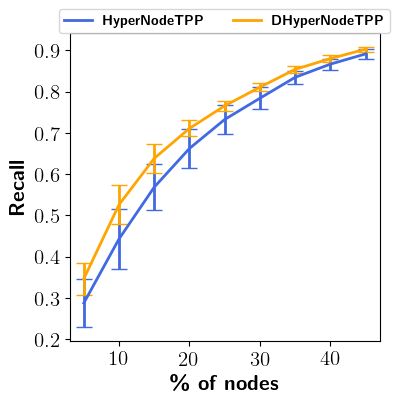

In [12]:
from matplotlib.lines import Line2D
barWidth = 2
fig = plt.subplots(figsize =(4, 4))
x1 = [i for i in range(5, 50, 5)]
# Make the plot
plt.errorbar(x1, micro_recall_undir_mean, yerr= micro_recall_undir_std,  label =r'\textbf{HyperNodeTPP}', color ='royalblue', linewidth=2, capsize=6)
plt.errorbar(x1, micro_recall_dir_mean, yerr= micro_recall_dir_std, label =r'\textbf{DHyperNodeTPP}', color= 'orange', linewidth=2, capsize=6)
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
legend_properties = {'weight':'bold'}
plt.legend(custom_lines,[r'\textbf{HyperNodeTPP}',r'\textbf{DHyperNodeTPP}'], prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.xlabel(r'\textbf{\% of nodes}', fontsize = 15)
plt.ylabel(r'\textbf{Recall}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
plt.xticks(fontweight = 'bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/connectivity.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

In [13]:
# x = [i for i in range(5, 50, 5)]
# lines=plt.plot(x, micro_recall_undir_mean)
# plt.setp(lines,color='red',marker='.')

# lines=plt.plot(x, micro_recall_dir_mean)
# plt.setp(lines,color='green',marker='.')

# plt.grid(True)
# plt.legend(['Undir','Dir'])
# plt.xlabel('Percentage of Total Nodes comprised of node with highest probability')
# plt.ylabel(r'\textbf{Recall}')
# plt.title(f'Abalation Study on Connectivity Modeling on Test Dataset for '+ files[arg['fileID']] +f' Dataset on Seed {seed}')
# plt.show()

## Eumail

In [14]:
## eumail
arg ={}
arg['fileID'] = 1  ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset

In [16]:
valid_folders = [files[arg['fileID']]+"_alpha0.1seed"+str(i) for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.1seed"+str(i) for i in range(3)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if file.endswith('train.csv') or file.endswith('train.txt') : arg[folder+'_train'] = file
            elif file.endswith('valid.csv') or file.endswith('valid.txt'): arg[folder+'_valid'] = file
            elif  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [17]:
file_Id = arg['fileID']
path = './directed_datasets/'
step = None
if files[file_Id] == 'enron':
    file_name = path + 'enron/'
elif files[file_Id] == 'eumail':
    file_name = path + 'eumail/'
elif files[file_Id] == 'hepth':
    file_name = path + 'hepth/'
elif files[file_Id] == 'arxiv':
    file_name = path + 'arxiv_25/'
    #step = 60 * 60
elif files[file_Id] == 'twitter':
    file_name = path + 'twitter/'
else:
    raise "Not implemented for the rest of the dataset"
data_dir = HyperDiEdgeDataset(file_name, step, type='directed')  # model type is directed
data_undir = HyperDiEdgeDataset(file_name, step, type='undirected') # model type is undirected

assert data_dir.n_nodes == data_undir.n_nodes
nnodes = data_dir.n_nodes

No of isolated nodes 0
No of isolated nodes 0


In [18]:
def batching_data(batch, dataset):
    batch_edges = []
    batch_time_cur = []
    batch_time_prev = []
    batch_connectives = []
    for _id in batch:
        edge,  time_cur, time_prev, connectives  = dataset.__getitem__(_id)
        batch_edges.append(edge)
        batch_time_cur.append(time_cur)
        batch_time_prev.append(time_prev)
        batch_connectives.append(connectives)
    return batch_edges, batch_time_cur, batch_time_prev, batch_connectives

In [19]:
batch_size = 128
batch_ids = data_dir.batch_ids
N_batch = len(batch_ids)
N_train_Batches = len(batch_ids) // 2
iteration = tqdm(range(N_train_Batches))
sum=0
skipped = 0
for i in iteration:
    if i > 0.1 * len(iteration):
        sum += len(batch_ids[i])
    else:
        skipped += len(batch_ids[i])

Valid_time = (N_batch + N_train_Batches) // 2
iteration = tqdm(range(N_train_Batches, Valid_time))
val_num = 0
for i in iteration:
    val_num += len(batch_ids[i])

100%|██████████| 407/407 [00:00<00:00, 988466.55it/s]


In [20]:
micro_recall_dir, micro_recall_undir = [], []
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'directed')
                micro_recall_dir.append(get_metric_result_for_dir(data_dir,test_iterator, skipped+sum+val_num, onlyleft=arg['onlyleft']))
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'undirected')
                micro_recall_undir.append(get_metric_result_for_undir(data_undir, test_iterator, skipped+sum+val_num, directed=True))


********************* Undirected || Seed 0 *****************************


Average Jaccard Score (MICRO) 0.11201206288251823
Average Jaccard Score (MACRO) 0.10367581949951549
Averge Recall@K Score (MICRO) for k = [37, 75, 113, 151, 189, 227, 264, 302, 340] is  [0.630204625671356, 0.7657277118820165, 0.8307828745360234, 0.8717783120444467, 0.8996987467003056, 0.9209588918398666, 0.9364054743178757, 0.9486058730451497, 0.9586866492295765]

********************* Directed || Seed 0 *****************************
Average Jaccard Score (MICRO) 0.006246744071559153
Average Jaccard Score (MACRO) 0.006246744071559153
Averge Recall@K Score (MICRO) for k = [37, 75, 113, 151, 189, 227, 264, 302, 340] is  [0.5203919296988373, 0.6644852244481675, 0.7468176301725811, 0.8031577905826898, 0.8435400468739329, 0.8763720701245276, 0.9005439036158558, 0.9210136339330629, 0.9384029313064765]

********************* Undirected || Seed 1 *****************************
Average Jaccard Score (MICRO) 0.11800049674010452
Average Jaccard Score (MACRO) 0.10634314466040766
Averge Recall@K Sco

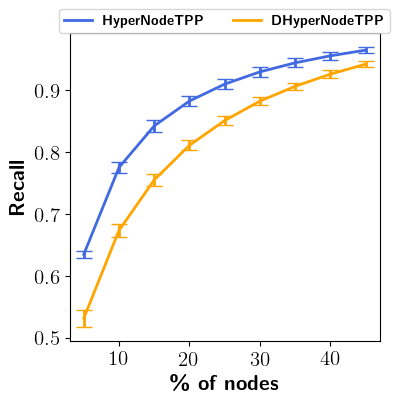

In [21]:
micro_recall_undir = np.array(micro_recall_undir)
micro_recall_undir_mean, micro_recall_undir_std = np.mean(micro_recall_undir,axis =0) , np.std(micro_recall_undir, axis = 0)
micro_recall_dir = np.array(micro_recall_dir)
micro_recall_dir_mean, micro_recall_dir_std = np.mean(micro_recall_dir,axis =0) , np.std(micro_recall_dir, axis = 0)
barWidth = 2
fig = plt.subplots(figsize =(4, 4))
x1 = [i for i in range(5, 50, 5)]
# Make the plot
plt.errorbar(x1, micro_recall_undir_mean, yerr= micro_recall_undir_std,  label =r'\textbf{HyperNodeTPP}', color ='royalblue', linewidth=2, capsize=6)
plt.errorbar(x1, micro_recall_dir_mean, yerr= micro_recall_dir_std, label =r'\textbf{DHyperNodeTPP}', color= 'orange', linewidth=2, capsize=6)
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
legend_properties = {'weight':'bold'}
plt.legend(custom_lines,[r'\textbf{HyperNodeTPP}',r'\textbf{DHyperNodeTPP}'], prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.xlabel(r'\textbf{\% of nodes}', fontsize = 15)
plt.ylabel(r'\textbf{Recall}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
plt.xticks(fontweight = 'bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/connectivity.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## Twitter

In [22]:
## Twitter
arg ={}
arg['fileID'] = 4  ## Enter dataset ID here 
arg['onlyleft'] = True ## If only left side is consider in directed dataset

In [23]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i) for i in range(4)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i) for i in range(4)]
valid_folders

['twitter_alpha0.3seed0',
 'twitter_alpha0.3seed1',
 'twitter_alpha0.3seed2',
 'twitter_alpha0.3seed3',
 'twitter_dir_alpha0.3seed0',
 'twitter_dir_alpha0.3seed1',
 'twitter_dir_alpha0.3seed2',
 'twitter_dir_alpha0.3seed3']

In [24]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i) for i in range(4)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i) for i in range(4)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if file.endswith('train.csv') or file.endswith('train.txt') : arg[folder+'_train'] = file
            elif file.endswith('valid.csv') or file.endswith('valid.txt'): arg[folder+'_valid'] = file
            elif  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file


In [25]:
file_Id = arg['fileID']
path = './directed_datasets/'
step = None
if files[file_Id] == 'enron':
    file_name = path + 'enron/'
elif files[file_Id] == 'eumail':
    file_name = path + 'eumail/'
elif files[file_Id] == 'hepth':
    file_name = path + 'hepth/'
elif files[file_Id] == 'arxiv':
    file_name = path + 'arxiv_25/'
    #step = 60 * 60
elif files[file_Id] == 'twitter':
    file_name = path + 'twitter/'
else:
    raise "Not implemented for the rest of the dataset"
data_dir = HyperDiEdgeDataset(file_name, step, type='directed')  # model type is directed
data_undir = HyperDiEdgeDataset(file_name, step, type='undirected') # model type is undirected

assert data_dir.n_nodes == data_undir.n_nodes
nnodes = data_dir.n_nodes

No of isolated nodes 0


No of isolated nodes 0


In [26]:
print('DATASET ::', files[file_Id])
micro_recall_dir, micro_recall_undir = [],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'directed' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'directed')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                del valid_iterator, train_iterator
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'directed')
                micro_recall_dir.append(get_metric_result_for_dir(data_dir,test_iterator, test_index_start, onlyleft=arg['onlyleft']))
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')

                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'undirected' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'undirected')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                del valid_iterator, train_iterator
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'undirected')
                micro_recall_undir.append(get_metric_result_for_undir(data_undir, test_iterator, test_index_start, directed=True))

DATASET :: twitter

********************* Undirected || Seed 0 *****************************


Average Jaccard Score (MICRO) 0.044745891134210174
Average Jaccard Score (MACRO) 0.0420658442555396
Averge Recall@K Score (MICRO) for k = [106, 212, 319, 425, 532, 638, 745, 851, 958] is  [0.5994609586990398, 0.7048596229422013, 0.7659454499161911, 0.8041045171967494, 0.828793504628942, 0.8498713986312383, 0.8699063956490066, 0.8943713031526783, 0.920526593725762]

********************* Directed || Seed 0 *****************************
Average Jaccard Score (MICRO) 0.003305600887200498
Average Jaccard Score (MACRO) 0.003305600887200498
Averge Recall@K Score (MICRO) for k = [106, 212, 319, 425, 532, 638, 745, 851, 958] is  [0.5865786762972064, 0.6923765466572347, 0.7517357620660983, 0.7953618898693177, 0.8380623502984722, 0.8613866239745834, 0.8882948918425853, 0.9083677724412673, 0.923285490896906]

********************* Undirected || Seed 1 *****************************
Average Jaccard Score (MICRO) 0.01976955207530778
Average Jaccard Score (MACRO) 0.018404509011402465
Averge Recall@K 

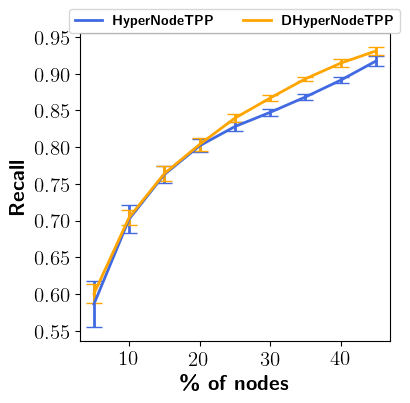

In [27]:
micro_recall_undir = np.array(micro_recall_undir)
micro_recall_undir_mean, micro_recall_undir_std = np.mean(micro_recall_undir,axis =0) , np.std(micro_recall_undir, axis = 0)
micro_recall_dir = np.array(micro_recall_dir)
micro_recall_dir_mean, micro_recall_dir_std = np.mean(micro_recall_dir,axis =0) , np.std(micro_recall_dir, axis = 0)
barWidth = 2
fig = plt.subplots(figsize =(4, 4))
x1 = [i for i in range(5, 50, 5)]
# Make the plot
plt.errorbar(x1, micro_recall_undir_mean, yerr= micro_recall_undir_std,  label =r'\textbf{HyperNodeTPP}', color ='royalblue', linewidth=2, capsize=6)
plt.errorbar(x1, micro_recall_dir_mean, yerr= micro_recall_dir_std, label =r'\textbf{DHyperNodeTPP}', color= 'orange', linewidth=2, capsize=6)
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
legend_properties = {'weight':'bold'}
plt.legend(custom_lines,[r'\textbf{HyperNodeTPP}',r'\textbf{DHyperNodeTPP}'], prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.xlabel(r'\textbf{\% of nodes}', fontsize = 15)
plt.ylabel(r'\textbf{Recall}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
plt.xticks(fontweight = 'bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/connectivity.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## Hepth

In [28]:
## hepth
arg ={}
arg['fileID'] = 2  ## Enter dataset ID here 
arg['onlyleft'] = False ## If only left side is consider in directed dataset, the flag is true.

In [29]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i)+'_1e-3' for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i)+'_1e-3'  for i in range(3)]
valid_folders

['hepth_alpha0.3seed0_1e-3',
 'hepth_alpha0.3seed1_1e-3',
 'hepth_alpha0.3seed2_1e-3',
 'hepth_dir_alpha0.3seed0_1e-3',
 'hepth_dir_alpha0.3seed1_1e-3',
 'hepth_dir_alpha0.3seed2_1e-3']

In [30]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i)+'_1e-3' for i in range(3)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i)+'_1e-3'  for i in range(3)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if file.endswith('train.csv') or file.endswith('train.txt') : arg[folder+'_train'] = file
            elif file.endswith('valid.csv') or file.endswith('valid.txt'): arg[folder+'_valid'] = file
            elif  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [31]:
file_Id = arg['fileID']
path = './directed_datasets/'
step = None
if files[file_Id] == 'enron':
    file_name = path + 'enron/'
elif files[file_Id] == 'eumail':
    file_name = path + 'eumail/'
elif files[file_Id] == 'hepth':
    file_name = path + 'hepth/'
elif files[file_Id] == 'arxiv':
    file_name = path + 'arxiv_25/'
    #step = 60 * 60
elif files[file_Id] == 'twitter':
    file_name = path + 'twitter/'
else:
    raise "Not implemented for the rest of the dataset"
data_dir = HyperDiEdgeDataset(file_name, step, type='directed')  # model type is directed
data_undir = HyperDiEdgeDataset(file_name, step, type='undirected') # model type is undirected

assert data_dir.n_nodes == data_undir.n_nodes
nnodes = data_dir.n_nodes

No of isolated nodes 0


No of isolated nodes 0


In [32]:
print('DATASET ::', files[file_Id])
micro_recall_dir, micro_recall_undir = [],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'directed' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'directed')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                del valid_iterator, train_iterator
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'directed')
                micro_recall_dir.append(get_metric_result_for_dir(data_dir,test_iterator, test_index_start, onlyleft=arg['onlyleft']))
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')

                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'undirected' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'undirected')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                del valid_iterator, train_iterator
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'undirected')
                micro_recall_undir.append(get_metric_result_for_undir(data_undir, test_iterator, test_index_start, directed=True))

DATASET :: hepth

********************* Undirected || Seed 0 *****************************


Average Jaccard Score (MICRO) 0.10481629151829923
Average Jaccard Score (MACRO) 0.08109828320762291
Averge Recall@K Score (MICRO) for k = [22, 45, 67, 90, 112, 135, 157, 180, 202] is  [0.22187265996462976, 0.33500988545148097, 0.4160244900531004, 0.49309577442891095, 0.549230234534303, 0.6047155627567988, 0.6545379726733236, 0.6998026934499025, 0.7365636935414046]

********************* Directed || Seed 0 *****************************
Average Jaccard Score (MICRO) 0.07112629142417358
Average Jaccard Score (MACRO) 0.06939604002365533
Averge Recall@K Score (MICRO) for k = [22, 45, 67, 90, 112, 135, 157, 180, 202] is  [0.3331958702307247, 0.4667643776345259, 0.5603264054762069, 0.6365373389507099, 0.695214756370883, 0.7473218713212408, 0.7928272291445604, 0.8281360287343253, 0.8610339401887577]

********************* Undirected || Seed 1 *****************************
Average Jaccard Score (MICRO) 0.10107225636983545
Average Jaccard Score (MACRO) 0.07760741920671756
Averge Recall@K Score (

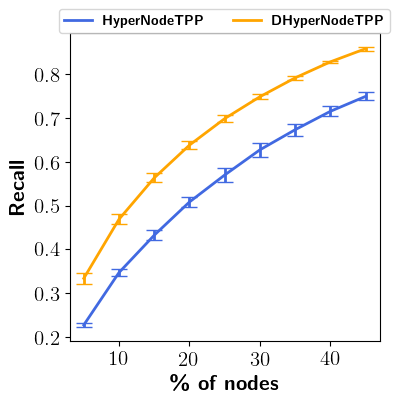

In [33]:
micro_recall_undir = np.array(micro_recall_undir)
micro_recall_undir_mean, micro_recall_undir_std = np.mean(micro_recall_undir,axis =0) , np.std(micro_recall_undir, axis = 0)
micro_recall_dir = np.array(micro_recall_dir)
micro_recall_dir_mean, micro_recall_dir_std = np.mean(micro_recall_dir,axis =0) , np.std(micro_recall_dir, axis = 0)
barWidth = 2
fig = plt.subplots(figsize =(4, 4))
x1 = [i for i in range(5, 50, 5)]
# Make the plot
plt.errorbar(x1, micro_recall_undir_mean, yerr= micro_recall_undir_std,  label =r'\textbf{HyperNodeTPP}', color ='royalblue', linewidth=2, capsize=6)
plt.errorbar(x1, micro_recall_dir_mean, yerr= micro_recall_dir_std, label =r'\textbf{DHyperNodeTPP}', color= 'orange', linewidth=2, capsize=6)
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
legend_properties = {'weight':'bold'}
plt.legend(custom_lines,[r'\textbf{HyperNodeTPP}',r'\textbf{DHyperNodeTPP}'], prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.xlabel(r'\textbf{\% of nodes}', fontsize = 15)
plt.ylabel(r'\textbf{Recall}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
plt.xticks(fontweight = 'bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/connectivity.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()

## arxiv 

In [10]:
## arxiv
arg ={}
arg['fileID'] = 3   ## Enter dataset ID here 
arg['onlyleft'] = False ## If only left side is consider in directed dataset

In [11]:
valid_folders = [files[arg['fileID']]+"_alpha0.3seed"+str(i)+'_1e-3' for i in range(2)] + [files[arg['fileID']]+"_dir_alpha0.3seed"+str(i)+'_1e-3' for i in range(2)]
subpath =  os.path.join(resultpath,files[arg['fileID']])
for folder in os.listdir(subpath):
    if folder in valid_folders:
        for file in os.listdir(os.path.join(subpath,folder)):
            if file.endswith('train.csv') or file.endswith('train.txt') : arg[folder+'_train'] = file
            elif file.endswith('valid.csv') or file.endswith('valid.txt'): arg[folder+'_valid'] = file
            elif  file.endswith('test.csv') or file.endswith('test.txt'): arg[folder+'_test'] = file

In [12]:
file_Id = arg['fileID']
path = './directed_datasets/'
step = None
if files[file_Id] == 'enron':
    file_name = path + 'enron/'
elif files[file_Id] == 'eumail':
    file_name = path + 'eumail/'
elif files[file_Id] == 'hepth':
    file_name = path + 'hepth/'
elif files[file_Id] == 'arxiv':
    file_name = path + 'arxiv_25/'
    #step = 60 * 60
elif files[file_Id] == 'twitter':
    file_name = path + 'twitter/'
else:
    raise "Not implemented for the rest of the dataset"
data_dir = HyperDiEdgeDataset(file_name, step, type='directed')  # model type is directed
data_undir = HyperDiEdgeDataset(file_name, step, type='undirected') # model type is undirected

assert data_dir.n_nodes == data_undir.n_nodes
nnodes = data_dir.n_nodes

No of isolated nodes 0


No of isolated nodes 0


In [13]:
print('DATASET ::', files[file_Id])
micro_recall_dir, micro_recall_undir = [],[]
for seed in range(4):
    for folder in valid_folders:
        if 'seed'+str(seed) in folder:
            if 'dir' in folder:
                print(f'\n********************* Directed || Seed {seed} *****************************')
                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'directed' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'directed')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                del valid_iterator, train_iterator
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'directed')
                micro_recall_dir.append(get_metric_result_for_dir(data_dir,test_iterator, test_index_start, onlyleft=arg['onlyleft']))
            else:
                print(f'\n********************* Undirected || Seed {seed} *****************************')

                train_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_train"]), dtype= 'directed', mtype= 'undirected' )
                valid_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_valid"]), dtype= 'directed', mtype= 'undirected')
                test_index_start = train_iterator.filesize + valid_iterator.filesize
                if arg[folder+"_train"].endswith('.txt'):
                    test_index_start -=2
                del valid_iterator, train_iterator
                test_iterator = IteratorForConnProb(os.path.join(subpath,folder,arg[folder+"_test"]), dtype= 'directed', mtype= 'undirected')
                micro_recall_undir.append(get_metric_result_for_undir(data_undir, test_iterator, test_index_start, directed=True))

DATASET :: arxiv

********************* Undirected || Seed 0 *****************************


Average Jaccard Score (MICRO) 0.09002582935017375
Average Jaccard Score (MACRO) 0.07933374353398945
Averge Recall@K Score (MICRO) for k = [32, 65, 98, 131, 164, 197, 230, 263, 296] is  [0.33020265272727367, 0.45991230837217095, 0.5509291880713872, 0.6171667691311308, 0.6734113438768391, 0.72055507255486, 0.759999868747389, 0.7917957265130285, 0.8195297696192198]

********************* Directed || Seed 0 *****************************
Average Jaccard Score (MICRO) 0.028619959420571398
Average Jaccard Score (MACRO) 0.02698929472006232
Averge Recall@K Score (MICRO) for k = [32, 65, 98, 131, 164, 197, 230, 263, 296] is  [0.3514245143397976, 0.49772508404441884, 0.5978024311326267, 0.6705316459507493, 0.7307621273007874, 0.776006009346737, 0.8088284230123395, 0.8400265986427721, 0.8657959105995761]

********************* Undirected || Seed 1 *****************************
Average Jaccard Score (MICRO) 0.09417014076950865
Average Jaccard Score (MACRO) 0.08269608797110067
Averge Recall@K Score 

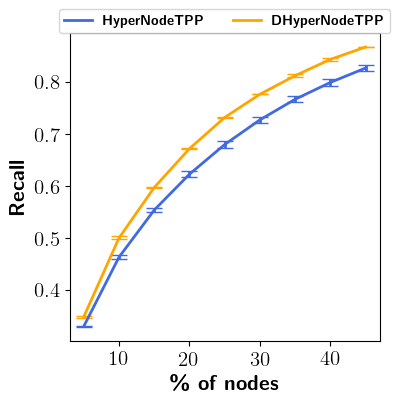

In [14]:
from matplotlib.lines import Line2D
micro_recall_undir = np.array(micro_recall_undir)
micro_recall_undir_mean, micro_recall_undir_std = np.mean(micro_recall_undir,axis =0) , np.std(micro_recall_undir, axis = 0)
micro_recall_dir = np.array(micro_recall_dir)
micro_recall_dir_mean, micro_recall_dir_std = np.mean(micro_recall_dir,axis =0) , np.std(micro_recall_dir, axis = 0)
barWidth = 2
fig = plt.subplots(figsize =(4, 4))
x1 = [i for i in range(5, 50, 5)]
# Make the plot
plt.errorbar(x1, micro_recall_undir_mean, yerr= micro_recall_undir_std,  label =r'\textbf{HyperNodeTPP}', color ='royalblue', linewidth=2, capsize=6)
plt.errorbar(x1, micro_recall_dir_mean, yerr= micro_recall_dir_std, label =r'\textbf{DHyperNodeTPP}', color= 'orange', linewidth=2, capsize=6)
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
legend_properties = {'weight':'bold'}
plt.legend(custom_lines,[r'\textbf{HyperNodeTPP}',r'\textbf{DHyperNodeTPP}'], prop=legend_properties, ncol = 2, loc=[-0.035,1])
plt.xlabel(r'\textbf{\% of nodes}', fontsize = 15)
plt.ylabel(r'\textbf{Recall}', fontsize = 15)
plt.yticks(fontweight ='bold',fontsize = 15)
plt.xticks(fontweight = 'bold',fontsize = 15)
pathlib.Path(f"./Plots/{files[arg['fileID']]}").mkdir(parents=True,exist_ok=True)
plt.savefig(f"./Plots/{files[arg['fileID']]}/connectivity.pdf",bbox_inches='tight', dpi = 1000, pad_inches=0)
plt.show()